In [2]:
from datetime import date
import yfinance as yf
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("../Resources/btcjoin.csv",parse_dates=['date'])
df = df.drop(columns=['volume','change', 'low', 'high', 'open'])
df = df.rename(columns={"value": "wallets"})
df['price']=df['price'].str.replace(',','')
df['price']=df['price'].astype("float")
df.head()
df

,date,price,wallets,address,mined
0,2010-09-25,0.1,2,656.0,4109450.00
1,2010-09-26,0.1,2,444.0,4110750.00
2,2010-09-27,0.1,2,1070.0,4132150.00
3,2010-09-28,0.1,2,1503.0,4133200.00
4,2010-09-29,0.1,2,1049.0,4148050.00
...,...,...,...,...,...
4381,2022-10-21,19162.6,84879615,924681.0,19185681.25
4382,2022-10-22,19204.8,84888147,830404.0,19186618.75
4383,2022-10-23,19571.2,84893809,804140.0,19187600.00
4384,2022-10-24,19331.5,84902680,919344.0,19188556.25


In [3]:
df_train = df[['date', 'price']]
df_train = df_train.rename(columns = {"date":"ds", "price":"y"})

m = Prophet()
m.fit(df_train)

n_years = 0
period = n_years * 365
future = m.make_future_dataframe(periods = period)
forecast = m.predict(future)

19:57:37 - cmdstanpy - INFO - Chain [1] start processing
19:57:38 - cmdstanpy - INFO - Chain [1] done processing


In [4]:
forecast[['ds', 'yhat', 'yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4381,2022-10-21,44874.712716,35506.617573,54380.940539
4382,2022-10-22,45071.105186,34951.683356,54854.896606
4383,2022-10-23,45244.704879,35982.049216,54285.702394
4384,2022-10-24,45449.054282,36247.093654,54857.408897
4385,2022-10-25,45612.718012,35807.794725,54511.214664


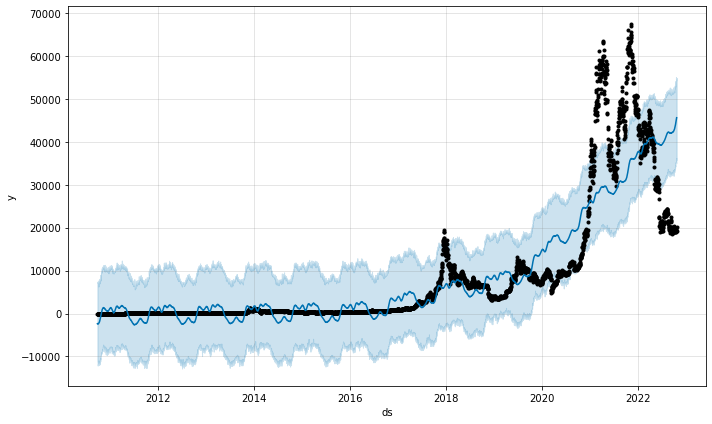

In [5]:
fig1 = m.plot(forecast)

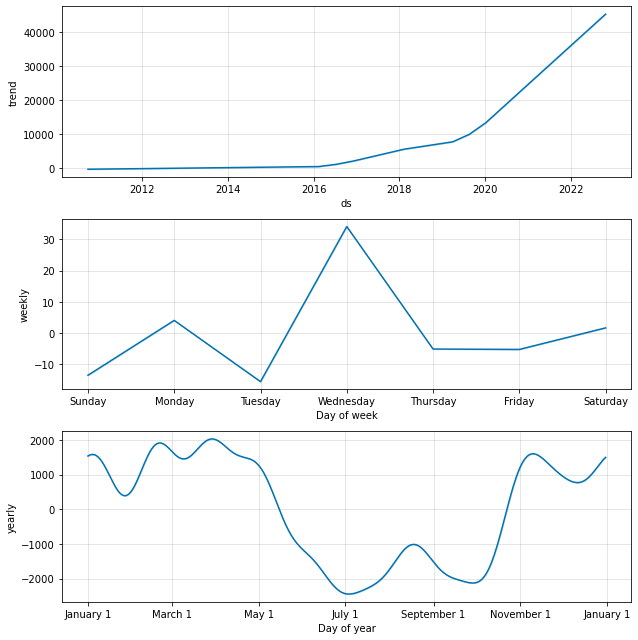

In [6]:
fig2 = m.plot_components(forecast)

In [7]:
df_train = df[['date', 'price']]
df_train = df_train.rename(columns = {"date":"ds", "price":"y"})

m = Prophet()
m.fit(df_train)

# instantiate the model and set parameters
model = Prophet()

# fit the model to historical data
model.fit(df_train);

19:57:40 - cmdstanpy - INFO - Chain [1] start processing
19:57:40 - cmdstanpy - INFO - Chain [1] done processing
19:57:41 - cmdstanpy - INFO - Chain [1] start processing
19:57:41 - cmdstanpy - INFO - Chain [1] done processing


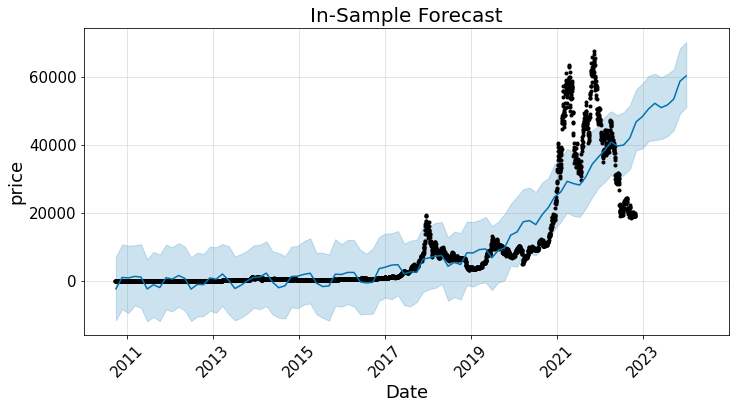

In [8]:
# Create a data frame that lists dates from Oct - Dec 2017
insample = pd.DataFrame(pd.date_range("2010-10-01", "2024-01-01", periods=92))

# Change the column name
insample.columns = ['ds']

# in-sample prediction
prediction = model.predict(insample)

# Plot
fig = model.plot(prediction, figsize=(10,5))
ax = fig.gca()
ax.set_title("In-Sample Forecast", size=20)
ax.set_xlabel("Date", size=18)
ax.set_ylabel("price", size=18)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.set_xlim(pd.to_datetime(['2010-01-01', '2024-12-31'])) 
plt.show();

In [9]:
# SMAPE function
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ 
                     (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

# Create a data frame of prediction and actual values
evaluation = pd.merge(
    # Prediction
    prediction[["ds", "yhat"]], 
    # Actual
    df_train[["ds", "y"]], 
    # Inner join on date
    how='inner', on='ds')

# MAPE and SMAPE
smape_kun(evaluation['y'],evaluation['yhat'])

MAPE: 2393057.98 % 
SMAPE: 200.00 %


In [10]:
import plotly.express as px

fig = px.line(x=df_train['ds'], y=df_train['y'])
fig.add_scatter(x=prediction['ds'], y=prediction['yhat'], name="Upper")
fig.add_scatter(x=prediction['ds'], y=prediction['yhat_lower'], name="Lower")
# fig.add_scatter(x=data.index, y=data['Open'], name="Open")

fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
            dict(count = 1, label = "1m", step = "month", stepmode = "backward"),
            dict(count = 6, label = "6m", step = "month", stepmode = "backward"),
            dict(count = 1, label = "YTD", step = "year", stepmode = "todate"),
            dict(count = 1, label = "1y", step = "year", stepmode = "backward"),
            dict(step = "all")
        ])
    )
)


fig.show()

In [11]:
## Addresses

In [12]:
df_trainw = df[['date', 'address']]
df_trainw = df_trainw.rename(columns = {"date":"ds", "address":"y"})

m = Prophet()
m.fit(df_trainw)

n_years = 3
period = n_years * 365
future = m.make_future_dataframe(periods = period)
forecastw = m.predict(future)

19:57:43 - cmdstanpy - INFO - Chain [1] start processing
19:57:45 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
forecastw[['ds', 'yhat', 'yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5476,2025-10-20,907386.780343,242592.264827,1.491929e+06
5477,2025-10-21,920086.917031,270273.518356,1.535313e+06
5478,2025-10-22,916872.212325,280411.130980,1.519573e+06
5479,2025-10-23,915624.359527,257549.901984,1.510811e+06
5480,2025-10-24,917193.703548,273358.367383,1.502059e+06


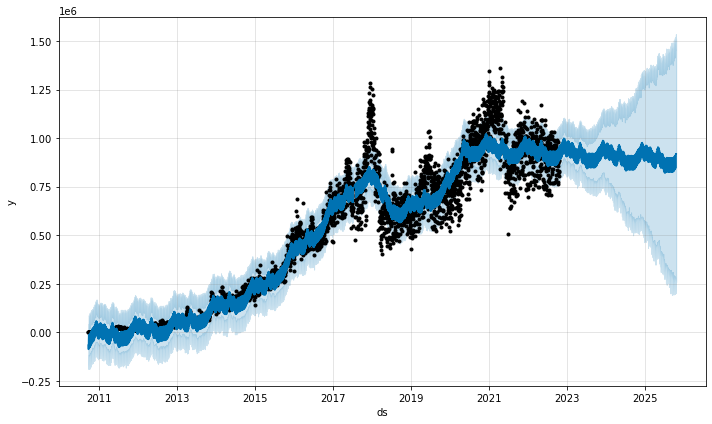

In [14]:
fig1 = m.plot(forecastw)

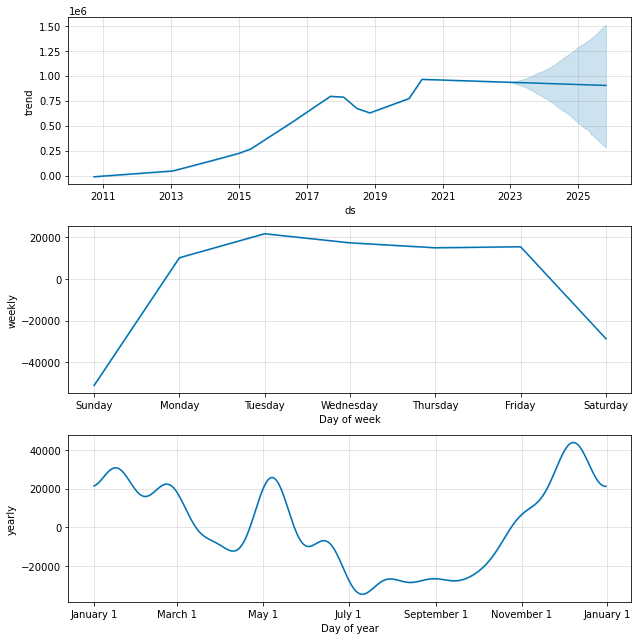

In [15]:
fig2 = m.plot_components(forecastw)

In [16]:
df_trainw = df[['date', 'address']]
df_trainw = df_trainw.rename(columns = {"date":"ds", "address":"y"})

m = Prophet()
m.fit(df_trainw)

# instantiate the model and set parameters
modelw = Prophet()

# fit the model to historical data
modelw.fit(df_trainw);

19:57:47 - cmdstanpy - INFO - Chain [1] start processing
19:57:48 - cmdstanpy - INFO - Chain [1] done processing
19:57:49 - cmdstanpy - INFO - Chain [1] start processing
19:57:50 - cmdstanpy - INFO - Chain [1] done processing


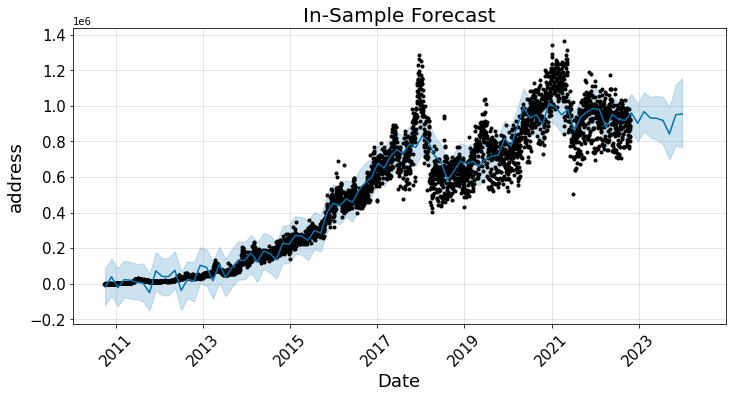

In [17]:
# Create a data frame that lists dates from Oct - Dec 2017
insample = pd.DataFrame(pd.date_range("2010-10-01", "2024-01-01", periods=92))

# Change the column name
insample.columns = ['ds']

# in-sample prediction
predictionw = modelw.predict(insample)

# Plot
fig = modelw.plot(predictionw, figsize=(10,5))
ax = fig.gca()
ax.set_title("In-Sample Forecast", size=20)
ax.set_xlabel("Date", size=18)
ax.set_ylabel("address", size=18)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.set_xlim(pd.to_datetime(['2010-01-01', '2024-12-31'])) 
plt.show();

In [18]:
# SMAPE function
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ 
                     (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

# Create a data frame of prediction and actual values
evaluationw = pd.merge(
    # Prediction
    predictionw[["ds", "yhat"]], 
    # Actual
    df_trainw[["ds", "y"]], 
    # Inner join on date
    how='inner', on='ds')

# MAPE and SMAPE
smape_kun(evaluationw['y'],evaluationw['yhat'])

MAPE: 2750.03 % 
SMAPE: 200.00 %


In [30]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(name="Actual", x=df_trainw['ds'], y=df_trainw['y'], legendrank=4))
fig.add_trace(go.Scatter(name="Upper Bound Prediction", x=predictionw['ds'], y=predictionw['yhat'], legendrank=2))
fig.add_trace(go.Scatter(name="Lower Bound Prediction", x=predictionw['ds'], y=predictionw['yhat_lower'], legendrank=1))

fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
            dict(count = 1, label = "1m", step = "month", stepmode = "backward"),
            dict(count = 6, label = "6m", step = "month", stepmode = "backward"),
            dict(count = 1, label = "YTD", step = "year", stepmode = "todate"),
            dict(count = 1, label = "1y", step = "year", stepmode = "backward"),
            dict(step = "all")
        ])
    )
)
fig.update_layout(title_text='Active Addressess and Date Prediction')
fig.update_yaxes(ticklabelposition="inside top", title="Active Addresses")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=20)

fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)

fig.show()
fig.write_html('../Website/images/trial.html')
